# A KNN based classifier to classify given set of features in Mushroom Database

## Importing the required libraries

In [72]:
import pandas as pd
from csv import reader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from math import sqrt
from numpy import array
from numpy import argmax
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [73]:
def load_csv(filename):
    dataset= pd.read_csv(filename,header=None)
    print (dataset.head())
    return dataset.as_matrix()

In [74]:
filename= '/home/smriti/Downloads/train_2.csv'
dataset = load_csv(filename)
dataset = np.delete(dataset, 11, 1)

attributes= []
cap_shape = ['b','c','x','f','k','s']
cap_surface = ['f', 'g' , 'y', 's']
cap_color = ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y']
bruises = ['t', 'f']
odor = ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's']
gill_attach = ['a', 'f', 'd', 'n']
gill_space = ['c', 'w' , 'd']
gill_size = ['b', 'n']
gill_color = ['k', 'n' , 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y']
stalk_shape = ['e', 't']
stalk_sabove = ['f', 'y' , 'k', 's']
stalk_sbelow = ['f', 'y' , 'k', 's']
stalk_cabove = ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y']
stalk_cbelow = ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y']
veil_type = ['p', 'u']
veil_color = ['n', 'o', 'w', 'y']
ring_num = ['n', 'o', 't']
ring_type = ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z']
spore = ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y']
population = ['a', 'c', 'n', 's', 'v', 'y']
habitat = ['g', 'l', 'm', 'p', 'u', 'w', 'd']


attributes.append(cap_shape)
attributes.append(cap_surface)
attributes.append(cap_color)
attributes.append(bruises)
attributes.append(odor)
attributes.append(gill_attach)
attributes.append(gill_space)
attributes.append(gill_size)
attributes.append(gill_color)
attributes.append(stalk_shape)
attributes.append(stalk_sabove)
attributes.append(stalk_sbelow)
attributes.append(stalk_cabove)
attributes.append(stalk_cbelow)
attributes.append(veil_type)
attributes.append(veil_color)
attributes.append(ring_num)
attributes.append(ring_type)
attributes.append(spore)
attributes.append(population)
attributes.append(habitat)

s= []
for i in range (0, len(dataset)):
    s.append(dataset[i][0])
new_dataset= pd.DataFrame(s)


  0  1  2  3  4  5  6  7  8  9  ... 13 14 15 16 17 18 19 20 21 22
0  e  k  s  n  f  n  a  c  b  y ...  s  o  o  p  n  o  p  b  c  l
1  e  k  s  g  f  n  f  w  b  p ...  s  w  w  p  w  t  p  w  s  g
2  e  b  s  g  f  n  f  w  b  w ...  s  w  w  p  w  t  p  w  s  g
3  e  s  f  g  f  n  f  c  n  n ...  s  w  w  p  w  o  p  n  v  u
4  e  f  f  g  f  n  f  w  b  p ...  f  w  w  p  w  o  e  n  a  g

[5 rows x 23 columns]


In [75]:
for i in range (0, len(attributes)):
    s= []
    for j in range (0, len(dataset)):
        s.append(dataset[j][i+1])
    encode= pd.get_dummies(s, columns=attributes[i])
    encode = encode.T.reindex(attributes[i]).T.fillna(0)
    
    df= pd.DataFrame(encode)

    new_dataset= pd.concat([new_dataset, df], axis= 1)
print(new_dataset.head())

   0  b  c  x  f  k  s  f  g  y ...  s  v  y  g  l  m  p  u  w  d
0  e  0  0  0  0  1  0  0  0  0 ...  0  0  0  0  1  0  0  0  0  0
1  e  0  0  0  0  1  0  0  0  0 ...  1  0  0  1  0  0  0  0  0  0
2  e  1  0  0  0  0  0  0  0  0 ...  1  0  0  1  0  0  0  0  0  0
3  e  0  0  0  0  0  1  1  0  0 ...  0  1  0  0  0  0  0  1  0  0
4  e  0  0  0  1  0  0  1  0  0 ...  0  0  0  1  0  0  0  0  0  0

[5 rows x 120 columns]


## Shuffle the dataset into train and test data

In [76]:
def split_data(new_dataset):
    random.shuffle(new_dataset)
    train_data = new_dataset[int(0.2*len(new_dataset)):]
    valid_data = new_dataset[int(0.8*len(new_dataset)):]
    return train_data, valid_data

In [77]:
train_data, valid_data= split_data(new_dataset.as_matrix())
print(len(train_data))
print(len(valid_data))

# print (train_data)

actual_labels= []
for line in valid_data:
    actual_labels.append(line[0])

3597
900


## Calculate Eculidean Distance

In [78]:
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(1,len(row1)-1):
        distance += (row1[i] - row2[i])**2
#     print (sqrt(distance))
    return sqrt(distance)

## Calculate Manhattan Distance

In [79]:
def manhattan_distance(row1, row2):
    distance = 0.0
    for i in range(1,len(row1)-1):
        distance += abs(row1[i] - row2[i])
#     print (distance)
    return distance

## Calculate 'k' nearest neighbours

In [80]:
def get_neighbors1(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
#         print (distances[i][0])
#     print (neighbors)  
    return neighbors

In [81]:
def get_neighbors2(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = manhattan_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
#         print (distances[i][0])
#     print (neighbors)  
    return neighbors

## Predict the Class of Mushroom

In [82]:
def predict_classification1(train, test_row, num_neighbors):
    neighbors = get_neighbors1(train, test_row, num_neighbors)
    output_values = [row[0] for row in neighbors]
#     print(output_values)
    prediction = max(set(output_values), key=output_values.count)
    return prediction

In [83]:
def predict_classification2(train, test_row, num_neighbors):
    neighbors = get_neighbors2(train, test_row, num_neighbors)
    output_values = [row[0] for row in neighbors]
#     print(output_values)
    prediction = max(set(output_values), key=output_values.count)
    return prediction

## Calculate Precision

In [84]:
def cal_precision(predicted_labels, actual_labels):
    prec= precision_score(actual_labels, predicted_labels, average=None)
    print ('Precision:', prec)
    print()
    return prec

## Calculate Recall

In [85]:
def cal_recall(predicted_labels, actual_labels):
    rec= recall_score(actual_labels, predicted_labels, average=None)
    print ('Recall:', rec)
    print()
    return rec

## Curve(Precision vs Recall)

In [86]:
def prec_vs_recall(prec, rec):
    plt.plot(rec, prec, label= "Precision vs Recall", linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

## Calculate Accuracy

In [87]:
def cal_accuracy(predicted_labels, actual_labels):
    acc= accuracy_score(actual_labels, predicted_labels)
    print ('Accuracy:', acc)
    print()
    return acc

## Calculate F1-Score

In [88]:
def cal_score(predicted_labels, actual_labels):
    print ('F1 score:', f1_score(actual_labels, predicted_labels, average=None))
    print()

## Classification Report

In [89]:
def class_report(predicted_labels, actual_labels):
    print ('Clasification report:', classification_report(actual_labels,predicted_labels))
    print()

## Confusion Matrix

In [90]:
def conf_matrix(predicted_labels, actual_labels):
    print ('Confussion matrix:\n\n',confusion_matrix(actual_labels, predicted_labels))
    print()

## Using Eculidean Distance

K= 3

Precision: [1. 1.]

Recall: [1. 1.]



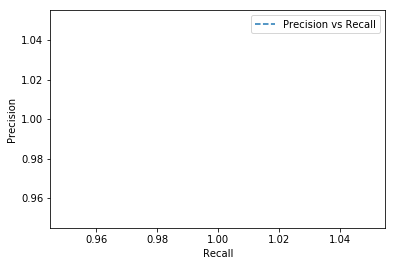

Accuracy: 1.0

F1 score: [1. 1.]

Clasification report:              precision    recall  f1-score   support

          e       1.00      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  0 535]]

*****
K= 5

Precision: [1. 1.]

Recall: [1. 1.]



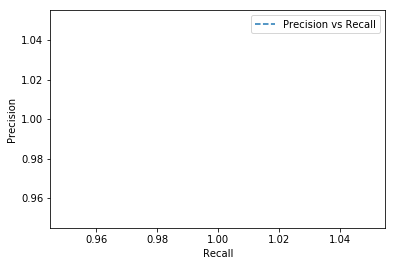

Accuracy: 1.0

F1 score: [1. 1.]

Clasification report:              precision    recall  f1-score   support

          e       1.00      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  0 535]]

*****
K= 7

Precision: [1. 1.]

Recall: [1. 1.]



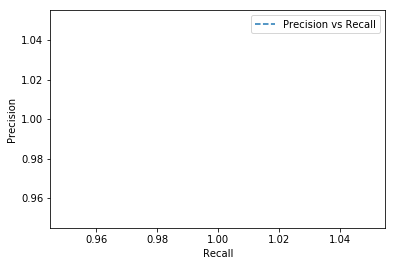

Accuracy: 1.0

F1 score: [1. 1.]

Clasification report:              precision    recall  f1-score   support

          e       1.00      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  0 535]]

*****
K= 9

Precision: [0.99455041 1.        ]

Recall: [1.         0.99626168]



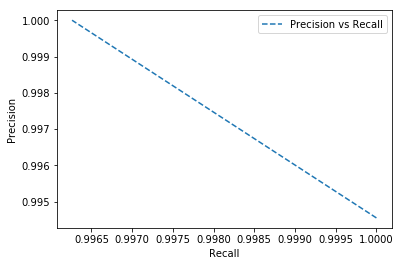

Accuracy: 0.9977777777777778

F1 score: [0.99726776 0.99812734]

Clasification report:              precision    recall  f1-score   support

          e       0.99      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  2 533]]

*****


In [91]:
kVals = range(3, 10, 2)
# num_neighbors= 10
scratch_accuraciese=[]
for num_neighbors in range(3, 10, 2):
    print ("K=", num_neighbors)
    print()
    predicted_labels =[]

#     count=0
    for row in valid_data:
        label = predict_classification1(train_data, row, num_neighbors)
        predicted_labels.append(label)
#         print("Actual:" , actual_labels[count], "Predicted:", label)
#         count +=1
        
    prec= cal_precision(predicted_labels, actual_labels)
    rec= cal_recall(predicted_labels, actual_labels)
    prec_vs_recall(prec, rec)
    scratch_accuraciese.append(cal_accuracy(predicted_labels, actual_labels))
    score= cal_score(predicted_labels, actual_labels)
    class_report(predicted_labels, actual_labels)
    conf_matrix(predicted_labels, actual_labels)
#     print("k=%d, accuracy=%.2f%%" % (num_neighbors, acc * 100))
    print("*****") 

In [92]:
print (scratch_accuraciese)
i = scratch_accuraciese.index(max(scratch_accuraciese))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % ((i*2) +3,
scratch_accuraciese[i] * 100))

[1.0, 1.0, 1.0, 0.9977777777777778]
k=3 achieved highest accuracy of 100.00% on validation data


Testing Accuracies vs K using Eculidean Distance



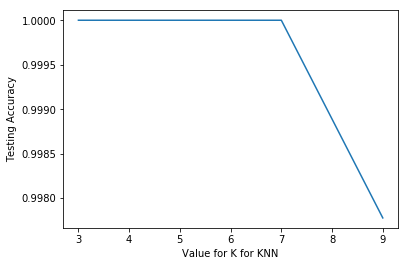

In [93]:
print ('Testing Accuracies vs K using Eculidean Distance')
print()
plt.plot(kVals, scratch_accuraciese)
plt.xlabel('Value for K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

## Using Manhattan Distance

K= 3

Precision: [1. 1.]

Recall: [1. 1.]



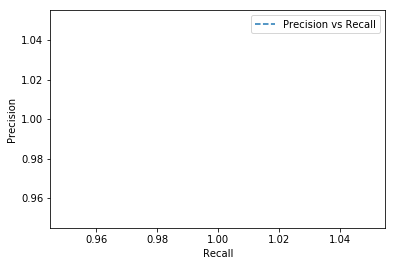

Accuracy: 1.0

F1 score: [1. 1.]

Clasification report:              precision    recall  f1-score   support

          e       1.00      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  0 535]]

*****
K= 5

Precision: [1. 1.]

Recall: [1. 1.]



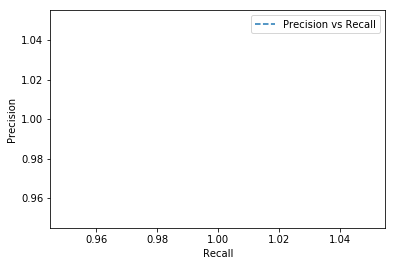

Accuracy: 1.0

F1 score: [1. 1.]

Clasification report:              precision    recall  f1-score   support

          e       1.00      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  0 535]]

*****
K= 7

Precision: [1. 1.]

Recall: [1. 1.]



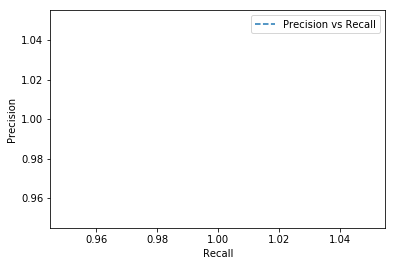

Accuracy: 1.0

F1 score: [1. 1.]

Clasification report:              precision    recall  f1-score   support

          e       1.00      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  0 535]]

*****
K= 9

Precision: [0.99455041 1.        ]

Recall: [1.         0.99626168]



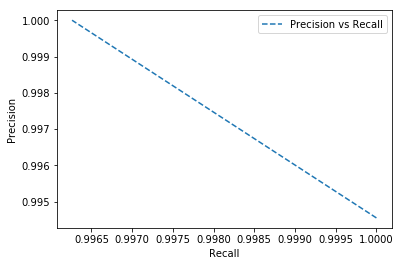

Accuracy: 0.9977777777777778

F1 score: [0.99726776 0.99812734]

Clasification report:              precision    recall  f1-score   support

          e       0.99      1.00      1.00       365
          p       1.00      1.00      1.00       535

avg / total       1.00      1.00      1.00       900


Confussion matrix:

 [[365   0]
 [  2 533]]

*****


In [94]:
# num_neighbors= 10
scratch_accuraciesm=[]
for num_neighbors in range(3, 10, 2):
    print ("K=", num_neighbors)
    print()
    predicted_labels =[]


    for row in valid_data:
        label = predict_classification2(train_data, row, num_neighbors)
        predicted_labels.append(label)
    prec= cal_precision(predicted_labels, actual_labels)
    rec= cal_recall(predicted_labels, actual_labels)
    prec_vs_recall(prec, rec)
    acc= cal_accuracy(predicted_labels, actual_labels)
    score= cal_score(predicted_labels, actual_labels)
    class_report(predicted_labels, actual_labels)
    conf_matrix(predicted_labels, actual_labels)
    scratch_accuraciesm.append(acc)
#     print("k=%d, accuracy=%.2f%%" % (num_neighbors, acc * 100))
    print("*****") 

In [95]:
i = np.argmax(scratch_accuraciesm)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % ((i*2) +3,
scratch_accuraciesm[i] * 100))

k=3 achieved highest accuracy of 100.00% on validation data


Testing Accuracies vs K using Manhattan Distance



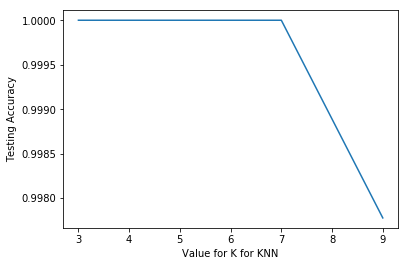

In [96]:
print ('Testing Accuracies vs K using Manhattan Distance')
print()
plt.plot(kVals, scratch_accuraciesm)
plt.xlabel('Value for K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()